In [1]:
%matplotlib inline
from utils import *
from tqdm import *
from os.path import join
from matplotlib import pyplot as plt
from skimage.measure import block_reduce
from multiprocessing import Pool
import numpy as np
import librosa
from tqdm import tqdm

from time import time
import matplotlib.cm as cm
from sklearn import metrics

from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
data_root = 'drumData'
n_fft = 1024
hop_length = n_fft/4
use_logamp = False # boost the brightness of quiet sounds
reduce_rows = 10 # how many frequency bands to average into one
reduce_cols = 1 # how many time steps to average into one
crop_rows = 32 # limit how many frequency bands to use
crop_cols = 32 # limit how many time steps to use
limit = None # set this to 100 to only process 100 samples

drumNames = ["kick", "tom", "snare", "clap", "hi.hat", "ride", "crash"]
drumFingerPrints = {}
drumSamples = {}
for d in drumNames:
    %time drumSamples[d] = np.load(join(data_root, d+'_samples.npy'))

CPU times: user 1.22 ms, sys: 218 ms, total: 219 ms
Wall time: 224 ms
CPU times: user 868 µs, sys: 13.9 ms, total: 14.8 ms
Wall time: 20.2 ms
CPU times: user 496 µs, sys: 103 ms, total: 103 ms
Wall time: 104 ms
CPU times: user 640 µs, sys: 54 ms, total: 54.7 ms
Wall time: 55.7 ms
CPU times: user 491 µs, sys: 5.26 ms, total: 5.75 ms
Wall time: 5.76 ms
CPU times: user 1.65 ms, sys: 9.67 ms, total: 11.3 ms
Wall time: 17.8 ms
CPU times: user 656 µs, sys: 30.7 ms, total: 31.3 ms
Wall time: 31.8 ms


# Load 6x24 MIR features

In [3]:
x_data_MIR = []
for drumName in drumNames: 
    file_path = './drumData/' + drumName + '_MIRfeatures.npy'
    drum_features = np.load(file_path)
    print(drum_features.shape)
    x_data_MIR.extend(drum_features)
x_data_MIR = np.asarray(x_data_MIR)
print("x_data_MIR.shape:", x_data_MIR.shape)
x_data_MIR = x_data_MIR.reshape(len(x_data_MIR),-1)
print("x_data_MIR.shape:", x_data_MIR.shape)

(5158, 6, 24)
(422, 6, 24)
(2546, 6, 24)
(1324, 6, 24)
(159, 6, 24)
(228, 6, 24)
(723, 6, 24)
('x_data_MIR.shape:', (10560, 6, 24))
('x_data_MIR.shape:', (10560, 144))


# Load 32x32 STFT features

In [4]:
import pickle
data_root = 'drumData/'
initial_dims = [30]
perplexities = [30]
mode = 'fingerprints'
drumNames = pickle.load(open(data_root+'drumNames.pickle'))
drumLengths = pickle.load(open(data_root+'drumLengths.pickle'))

drumPrints = []
drumLabels = []
for i, drum in enumerate(drumNames):
    STFT_feat = np.load(join(data_root, drum+'_fingerprints.npy'))
    drumPrints.extend(STFT_feat)
    drumLabels.extend([i] * STFT_feat.shape[0])

x_data_STFT = np.asarray(drumPrints)
print("x_data_STFT.shape:", x_data_STFT.shape)
x_data_STFT = x_data_STFT.reshape(len(x_data_STFT),-1)
print("x_data_STFT.shape:", x_data_STFT.shape)

('x_data_STFT.shape:', (10560, 32, 32))
('x_data_STFT.shape:', (10560, 1024))


# Load MFCC features

In [22]:
x_data_MFCC = []
for drumName in drumNames: 
    file_path = './drumData/' + drumName + '_MFCCs.npy'
    drum_features = np.load(file_path)
    x_data_MFCC.extend(drum_features)
x_data_MFCC = np.asarray(x_data_MFCC)
print("x_data_MFCC.shape:", x_data_MFCC.shape)
x_data_MFCC = x_data_MFCC.reshape(len(x_data_MFCC),-1)
print("x_data_MFCC.shape:", x_data_MFCC.shape)

('x_data_MFCC.shape:', (10560, 30, 24))
('x_data_MFCC.shape:', (10560, 720))


# Load Wavenet features 23x16

In [23]:
x_data_Wavenet = []
for drumName in drumNames: 
    file_path = './drumData/' + drumName + '_wavenet.npy'
    drum_features = np.load(file_path)
    x_data_Wavenet.extend(drum_features)
x_data_Wavenet = np.asarray(x_data_Wavenet)
print("x_data_Wavenet.shape:", x_data_Wavenet.shape)
x_data_Wavenet = x_data_Wavenet.reshape(len(x_data_Wavenet),-1)
print("x_data_Wavenet.shape:", x_data_Wavenet.shape)

('x_data_Wavenet.shape:', (10560, 23, 16))
('x_data_Wavenet.shape:', (10560, 368))


# Create ground truth labels

('y_data.shape:', (10560,))


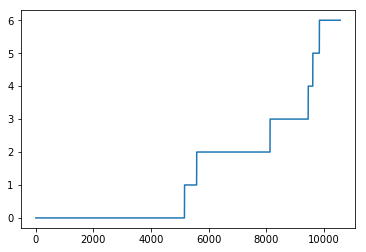

In [6]:
drumLabels = []
for i, drum in enumerate(drumNames):
    STFT_feat = np.load(join(data_root, drum+'_fingerprints.npy'))
    drumPrints.extend(STFT_feat)
    drumLabels.extend([i] * STFT_feat.shape[0])
y_data = np.asarray(drumLabels)
print("y_data.shape:", y_data.shape)
plt.figure()
plt.plot(y_data)

# Create ground truth color map

In [7]:
import itertools
def concatColors(segmentList, colorList):
    multiples = []
    #print segmentList, colorList
    for i in range(len(segmentList)):
        multiples.append([colorList[i]]*segmentList[i])
    return list(itertools.chain(*multiples))

colors = ['#000000', '#ff0000', '#00ff00', '#0000ff', '#ffff00', '#ff00ff', '#00ffff']
drumLengths = [5158,422,2546,1324,159,228,723]
colorMap = concatColors(drumLengths, colors)

In [8]:
def computeSilCoeff(data, cluster_labels):
    silhouette_avg = silhouette_score(data, cluster_labels)
    print("The average silhouette_score is :", silhouette_avg)

def plotSampleSilCoeff(data, cluster_labels, title):
    fig, ax1 = plt.subplots()
    silhouette_avg = silhouette_score(data, cluster_labels)
    sample_silhouette_values = silhouette_samples(data, cluster_labels)
    
    n_clusters = 7
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    #ax1.set_title("Av. Sil Coeff:", silhouette_avg)
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# Evaluating TSNE

In [9]:
def get_scaled_tsne_embeddings(features, perplexity, iteration):
    embedding = TSNE(n_components=2,
                     perplexity=perplexity,
                     n_iter=iteration).fit_transform(features)
    scaler = MinMaxScaler()
    scaler.fit(embedding)
    return scaler.transform(embedding)

In [ ]:
tnse_embeddings_mfccs = []
tnse_embeddings_MIR = []
tnse_embeddings_STFT = []
tnse_embeddings_Wavenet = []
perplexities = [50]
iterations = [500]
for i, perplexity in enumerate(perplexities):
    for j, iteration in enumerate(iterations):
        #%time tsne_mfccs = get_scaled_tsne_embeddings(x_data_MFCC,perplexity,iteration)
        #%time tsne_MIR = get_scaled_tsne_embeddings(x_data_MIR,perplexity,iteration)
        #%time tsne_STFT = get_scaled_tsne_embeddings(x_data_STFT,perplexity,iteration)
        %time tsne_wavenet = get_scaled_tsne_embeddings(x_data_Wavenet,perplexity,iteration)
        #tnse_embeddings_mfccs.append(tsne_mfccs)
        #tnse_embeddings_MIR.append(tsne_MIR)
        #tnse_embeddings_STFT.append(tsne_STFT)
        tnse_embeddings_Wavenet.append(tsne_Wavenet)

In [12]:
print(len(tnse_embeddings_mfccs[0]))
print(tnse_embeddings_mfccs[0].shape)

#np.save("./drumEmbeddings/tnse_embeddings_mfccs.npy",tnse_embeddings_mfccs[0])
#np.save("./drumEmbeddings/tnse_embeddings_MIR.npy",tnse_embeddings_MIR[0])
#np.save("./drumEmbeddings/tnse_embeddings_STFT.npy",tnse_embeddings_STFT[0])
np.save("./drumEmbeddings/tnse_embeddings_Wavenet.npy",tnse_embeddings_Wavenet[0])

10560
(10560, 2)


# TSNE on MFCC 

('The average silhouette_score is :', 0.036674164)


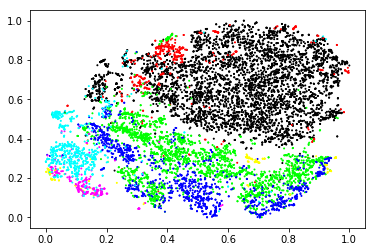

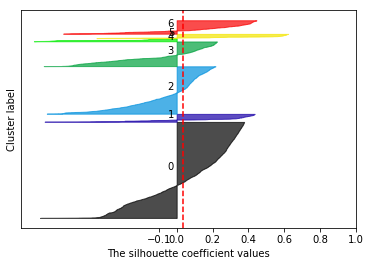

In [22]:
plt.scatter(tnse_embeddings_mfccs[0].T[0], 
                    tnse_embeddings_mfccs[0].T[1],
                    c=colorMap,
                    s=1)
computeSilCoeff(tnse_embeddings_mfccs[0],y_data)
plotSampleSilCoeff(tnse_embeddings_mfccs[0], y_data, "TSNE MFCC")

('The average silhouette_score is :', 0.033833168)


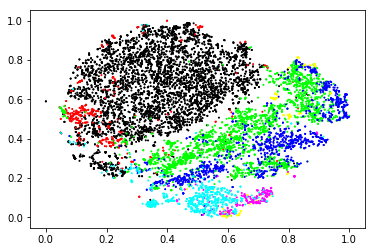

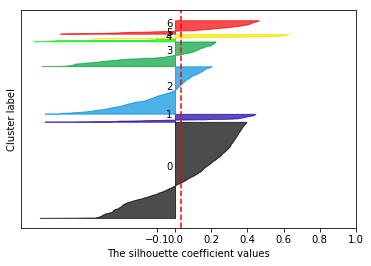

In [13]:
plt.scatter(tnse_embeddings_mfccs[0].T[0], 
                    tnse_embeddings_mfccs[0].T[1],
                    c=colorMap,
                    s=1)
computeSilCoeff(tnse_embeddings_mfccs[0],y_data)
plotSampleSilCoeff(tnse_embeddings_mfccs[0], y_data, "TSNE MFCC")

# TSNE on MIR features

('The average silhouette_score is :', -0.064286284)


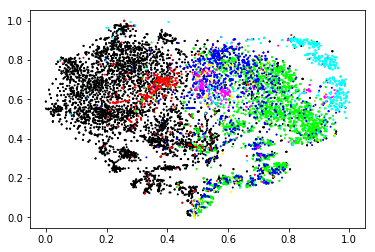

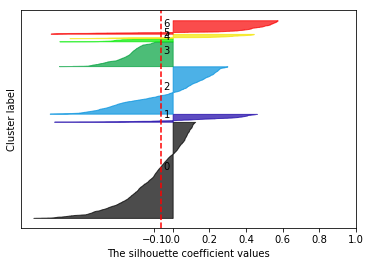

In [23]:
plt.scatter(tnse_embeddings_MIR[0].T[0], 
                    tnse_embeddings_MIR[0].T[1],
                    c=colorMap,
                    s=1)
computeSilCoeff(tnse_embeddings_MIR[0],y_data)
plotSampleSilCoeff(tnse_embeddings_MIR[0], y_data, "TSNE MIR")

('The average silhouette_score is :', -0.062795788)


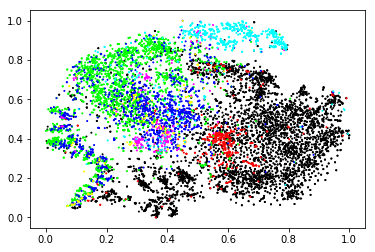

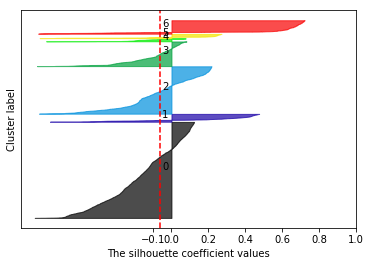

In [14]:
plt.scatter(tnse_embeddings_MIR[0].T[0], 
                    tnse_embeddings_MIR[0].T[1],
                    c=colorMap,
                    s=1)
computeSilCoeff(tnse_embeddings_MIR[0],y_data)
plotSampleSilCoeff(tnse_embeddings_MIR[0], y_data, "TSNE MIR")

# TSNE on STFT features

('The average silhouette_score is :', 0.053192236)


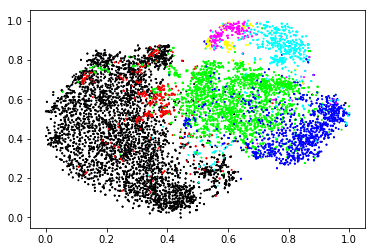

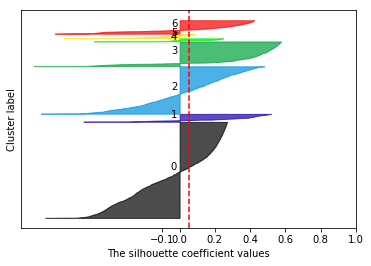

In [24]:
plt.scatter(tnse_embeddings_STFT[0].T[0], 
                    tnse_embeddings_STFT[0].T[1],
                    c=colorMap,
                    s=1)
computeSilCoeff(tnse_embeddings_STFT[0],y_data)
plotSampleSilCoeff(tnse_embeddings_STFT[0], y_data, "TSNE STFT")

('The average silhouette_score is :', 0.039712295)


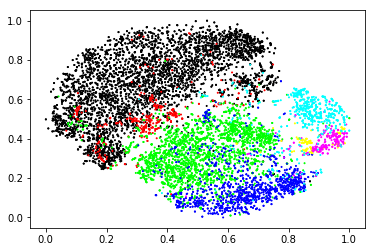

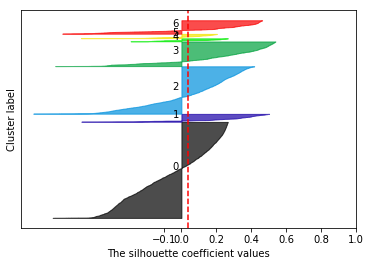

In [15]:
plt.scatter(tnse_embeddings_STFT[0].T[0], 
                    tnse_embeddings_STFT[0].T[1],
                    c=colorMap,
                    s=1)
computeSilCoeff(tnse_embeddings_STFT[0],y_data)
plotSampleSilCoeff(tnse_embeddings_STFT[0], y_data, "TSNE STFT")

# TSNE on Wavenet

In [ ]:
plt.scatter(tnse_embeddings_Wavenet[0].T[0], 
                    tnse_embeddings_Wavenet[0].T[1],
                    c=colorMap,
                    s=1)
computeSilCoeff(tnse_embeddings_Wavenet[0],y_data)
plotSampleSilCoeff(tnse_embeddings_Wavenet[0], y_data, "TSNE Wavenet")

# Geometrics Metrics

In [18]:
import numpy as np
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, MultiPolygon, Point

def clusterGeometryMetrics(drum_points, labels):
    
    grouped_drum_points = {}
    
    for i in range(len(drum_points)):
        if labels[i] not in grouped_drum_points:
            grouped_drum_points[labels[i]] = list()
        grouped_drum_points[labels[i]].append(drum_points[i])
    
    num_labels = len(grouped_drum_points)
    drum_polygons = {}
    
    for drum in grouped_drum_points:
        points = grouped_drum_points[drum]
        hull = ConvexHull(grouped_drum_points[drum])
        drum_polygons[drum] = Polygon([points[v] for v in hull.vertices])
    
    total_hull = ConvexHull(drum_points)
    total_polygon = Polygon([drum_points[v] for v in total_hull.vertices])
    p = [Point(c) for c in total_polygon.exterior.coords]
    total_diameter = max([p1.distance(p2) for p1 in p for p2 in p])
    
    calc_intersect = lambda i, j: drum_polygons[i].intersection(drum_polygons[j]).area / total_polygon.area
    calc_roundness = lambda poly : 4 * np.pi * poly.area / (poly.length**2)
    calc_distance = lambda i, j: drum_polygons[i].distance(drum_polygons[j]) / total_diameter
    
    #overlap areas between the polygons of the different clusters, normalized by area of total plot polygon
    pairwise_intersect_areas = [[calc_intersect(i,j) for i in range(num_labels)] for j in range(num_labels)]
    
    
    # Distance between nearest points of 2 polygons normalized by "diameter" of total plot polygon
    pairwise_distances = [[calc_distance(i,j) for i in range(num_labels)] for j in range(num_labels)]
    
    #measure of "roundness" of each polygon based on Polsby-Popper Test
    roundness = [calc_roundness(drum_polygons[d]) for d in drum_polygons]
    
    #relative sizes of each cluster polygon normalized by area of total plot polygon
    relative_areas = [drum_polygons[d].area / total_polygon.area for d in drum_polygons]
    
    #the polygons themselves for further processing 
    polygons = drum_polygons.values() + [total_polygon]
    
    #the area of the union of all cluser polygons over the area of the total plot
    overlap_ratio = reduce(lambda a,b: a.union(b), polygons[1:], polygons[0]).area / sum([p.area for p in polygons])
    
    returnVal = {}
    returnVal['pairwise_intersect_areas'] = pairwise_intersect_areas
    returnVal['roundness'] = roundness
    returnVal['relative_areas'] = relative_areas
    returnVal['overlap_ratio'] = overlap_ratio
    returnVal['polygons'] = polygons
    returnVal['pairwise_distances'] = pairwise_distances
    return returnVal

# Geometry on MFCC's

In [19]:
print(tnse_embeddings_mfccs[0].shape)
MFCC_metrics = clusterGeometryMetrics(tnse_embeddings_mfccs[0],y_data)

for key in MFCC_metrics:
    print key, MFCC_metrics[key]
    print 

(10560, 2)
pairwise_intersect_areas [[0.8249679227256675, 0.7296750599713248, 0.6256839627067329, 0.4531849753618836, 0.1700435153890655, 0.10680275456687667, 0.6944344462158936], [0.7296750599713248, 0.7334463411957481, 0.5651043604139878, 0.3948429375203845, 0.11704646544765772, 0.07841766446928859, 0.6327170458356869], [0.625683962706733, 0.5651043604139877, 0.764802683071397, 0.5570918913012072, 0.24151510645502106, 0.17891462593484123, 0.6696657176212928], [0.4531849753618836, 0.39484293752038446, 0.5570918913012068, 0.5593112407440581, 0.22292427901670842, 0.16059873988451145, 0.4923546513768485], [0.1700435153890655, 0.11704646544765775, 0.24151510645502114, 0.22292427901670847, 0.250451997771866, 0.13659632355242482, 0.21512344347148546], [0.10680275456687666, 0.07841766446928859, 0.1789146259348412, 0.16059873988451143, 0.13659632355242482, 0.19064813845790207, 0.18819865883872844], [0.6944344462158936, 0.6327170458356867, 0.6696657176212927, 0.49235465137684853, 0.21512344347

# Geometry on MIR

In [20]:
print(tnse_embeddings_MIR[0].shape)
MIR_metrics = clusterGeometryMetrics(tnse_embeddings_MIR[0],y_data)

for key in MIR_metrics:
    print key, MIR_metrics[key]
    print 

(10560, 2)
pairwise_intersect_areas [[0.9756197573778617, 0.6804276926683569, 0.7212226736494551, 0.7524378687891107, 0.3761441466132222, 0.3810252987673355, 0.7053926491772382], [0.6804276926683568, 0.6804362080498556, 0.5326498572450732, 0.5821504144621424, 0.2692842711197256, 0.2723480006268831, 0.5332251939607939], [0.7212226736494551, 0.5326498572450731, 0.7339918105859529, 0.6961699108074105, 0.37590661791490176, 0.3804762565693843, 0.584112444493911], [0.7524378687891107, 0.5821504144621426, 0.6961699108074104, 0.7631866802329231, 0.37801104623939163, 0.3706698148779573, 0.6288457375153503], [0.37614414661322226, 0.2692842711197257, 0.37590661791490176, 0.37801104623939175, 0.37916951354425554, 0.2884785507936884, 0.3071993415607965], [0.3810252987673355, 0.272348000626883, 0.38047625656938433, 0.37066981487795725, 0.28847855079368845, 0.3811046590834724, 0.3568045150252549], [0.7053926491772382, 0.5332251939607939, 0.5841124444939109, 0.6288457375153504, 0.3071993415607964, 0.3

# Geometry on STFT

In [21]:
print(tnse_embeddings_STFT[0].shape)
STFT_metrics = clusterGeometryMetrics(tnse_embeddings_STFT[0],y_data)

for key in STFT_metrics:
    print key, STFT_metrics[key]
    print 

(10560, 2)
pairwise_intersect_areas [[0.8223005456806273, 0.5562779977931411, 0.5558483119135896, 0.30359039551514666, 0.02843084748150344, 0.08913755780882257, 0.41431495018133385], [0.5562779977931411, 0.5562779977931411, 0.43392558376529244, 0.18892894254377443, 0.004850721527014305, 0.006621554868763865, 0.2989128418682081], [0.5558483119135896, 0.4339255837652925, 0.6731977123267648, 0.3704485194712264, 0.0523167393436037, 0.1419598866018859, 0.4639215187737397], [0.30359039551514666, 0.18892894254377443, 0.3704485194712262, 0.38238346803498313, 0.033017893690750706, 0.10059244586522177, 0.32591738514260876], [0.02843084748150344, 0.004850721527014304, 0.0523167393436037, 0.033017893690750706, 0.05515738336586061, 0.049152925656100764, 0.055028397188354644], [0.08913755780882257, 0.006621554868763865, 0.1419598866018859, 0.10059244586522177, 0.049152925656100764, 0.1511945382939921, 0.15101694086253212], [0.41431495018133396, 0.2989128418682081, 0.46392151877373955, 0.325917385142

# Geometry on Wavenet

In [ ]:
print(tnse_embeddings_Wavenet[0].shape)
Wavenet_metrics = clusterGeometryMetrics(tnse_embeddings_Wavenet[0],y_data)

for key in Wavenet_metrics:
    print key, Wavenet_metrics[key]
    print 

# Evaluate TSNE across many perplexities and iterations

In [ ]:
"""
tnse_embeddings_mfccs = []
perplexities = [2, 5, 30, 50, 100]
iterations = [250, 500, 1000, 2000, 5000]
for i, perplexity in enumerate(perplexities):
    for j, iteration in enumerate(iterations):
        %time tsne_mfccs = get_scaled_tsne_embeddings(x_data_MFCC,perplexity,iteration)
        tnse_embeddings_mfccs.append(tsne_mfccs)
"""

In [ ]:
fig, ax = plt.subplots(nrows=len(perplexities), 
                       ncols=len(iterations),
                       figsize=(30, 30))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        current_plot = i * len(iterations) + j
        col.scatter(tnse_embeddings_mfccs[current_plot].T[0], 
                    tnse_embeddings_mfccs[current_plot].T[1],
                    c=colorMap,
                    s=1)
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=len(perplexities), 
                       ncols=len(iterations),
                       figsize=(30, 30))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        current_plot = i * len(iterations) + j
        plotSampleSilCoeff(tnse_embeddings_mfccs[current_plot], y_data, "TSNE MFCC")
plt.show()